## Importing libraries

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

## Reading the dataset

In [342]:
data = pd.read_csv('used_cars_data.csv')
data.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


- The S.No. is simply a row identifier which can be removed.
- The Name is long string comprising the Brand, Model and addition specification. These can be split to further analyse by make and model.
- The Fuel_Type, Transmission and Owner_Type are categorical variable which can be possibly be one-hot encoded.
- Mileage, Engine and Power are strings leading with number and unit. These shall be split and numerical portion will be used in analysis.

In [343]:
data = data.drop(columns=['S.No.'])
data.columns = [col.lower() for col in data.columns] # column names converted to lower case for ease of use

## Shape of the dataset

In [344]:
data.shape
print(f"The Dataframe consists of '{data.shape[0]}' rows and '{data.shape[1]}' columns")

The Dataframe consists of '7253' rows and '13' columns


In [345]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               7253 non-null   object 
 1   location           7253 non-null   object 
 2   year               7253 non-null   int64  
 3   kilometers_driven  7253 non-null   int64  
 4   fuel_type          7253 non-null   object 
 5   transmission       7253 non-null   object 
 6   owner_type         7253 non-null   object 
 7   mileage            7251 non-null   object 
 8   engine             7207 non-null   object 
 9   power              7207 non-null   object 
 10  seats              7200 non-null   float64
 11  new_price          1006 non-null   object 
 12  price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


There seems to be some missing values in a few columns.

## Checking for duplicates

In [346]:
data.duplicated().sum()

np.int64(1)

In [347]:
data.drop_duplicates(inplace=True)

print(f"The Dataframe now consists of '{data.shape[0]}' rows and '{data.shape[1]}' columns")

The Dataframe now consists of '7252' rows and '13' columns


## Checking for missing values

In [348]:
data.isnull().sum()

name                    0
location                0
year                    0
kilometers_driven       0
fuel_type               0
transmission            0
owner_type              0
mileage                 2
engine                 46
power                  46
seats                  53
new_price            6246
price                1233
dtype: int64

There a lot of missing values that need to be dealt with.

## Data Summary

In [349]:
data.describe()

,year,kilometers_driven,seats,price
count,7252.000000,7.252000e+03,7199.000000,6019.000000
mean,2013.365830,5.869999e+04,5.279761,9.479468
std,3.254405,8.443351e+04,0.811709,11.187917
min,1996.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.342900e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


# Data Cleaning & Feature Engineering

## Categorical Columns

### name column

In [350]:
data["make"] = data["name"].str.split(" ").str[0]
data["model"] = data["name"].str.split(" ").str[1]
data = data.drop(columns = ['name'])

In [351]:
data["make"].value_counts(dropna = False)

make
Maruti           1444
Hyundai          1340
Honda             742
Toyota            507
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          331
BMW               312
Audi              285
Tata              228
Skoda             202
Renault           170
Chevrolet         151
Nissan            117
Land               67
Jaguar             48
Fiat               38
Mitsubishi         36
Mini               31
Volvo              28
Jeep               19
Porsche            19
Datsun             17
Force               3
ISUZU               3
Isuzu               2
Bentley             2
Smart               1
Ambassador          1
Lamborghini         1
Hindustan           1
OpelCorsa           1
Name: count, dtype: int64

In [352]:
make_counts = data['make'].value_counts(normalize=True) * 100  #Calculate the percentage of each make
rare_makes = make_counts[make_counts < 1].index  #Makes with less than 1% occurrence
data['make'] = data['make'].replace(rare_makes, 'Others') # Replace them with 'Others'
data["make"].value_counts()

make
Maruti           1444
Hyundai          1340
Honda             742
Toyota            507
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          331
Others            318
BMW               312
Audi              285
Tata              228
Skoda             202
Renault           170
Chevrolet         151
Nissan            117
Name: count, dtype: int64

There are 33 different car brands of which MARUTI is the most popular.

In [353]:
data["model"].value_counts()

model
Swift     418
City      317
i20       303
Innova    203
Verna     200
         ... 
Land        1
MU          1
370Z        1
Abarth      1
1.4Gsi      1
Name: count, Length: 219, dtype: int64

The dataset has 219 different car models out of which SWIFT is the most popular.

### location column

In [354]:
data["location"].value_counts()

location
Mumbai        948
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Ahmedabad     275
Name: count, dtype: int64

Mumbai is the most popular and Ahmedabad is the least popular location.

In [355]:
# Grouping locations into regions
region_mapping = {
    'Chennai': 'South',
    'Jaipur': 'North',
    'Pune': 'West',
    'Mumbai': 'West',
    'Kolkata': 'East',
    'Delhi': 'North',
    'Ahmedabad': 'West',
    'Hyderabad': 'South',
    'Coimbatore': 'South',
    'Bangalore': 'South',
    'Kochi': 'South'
}

data['region'] = data['location'].map(region_mapping)

### year column

In [356]:
data["year"].value_counts()

year
2015    929
2014    925
2016    886
2013    791
2017    709
2012    690
2011    579
2010    406
2018    361
2009    252
2008    207
2007    148
2019    119
2006     89
2005     68
2004     35
2003     20
2002     18
2001      8
2000      5
1998      4
1999      2
1996      1
Name: count, dtype: int64

There are 23 different years of manufacture of which 2015 is the most popular and 1996 is the least popular.

In [357]:
data["car_age"] = 2019 - data["year"] # since the dataset is from 2019
data["car_age"].value_counts()

car_age
4     929
5     925
3     886
6     791
2     709
7     690
8     579
9     406
1     361
10    252
11    207
12    148
0     119
13     89
14     68
15     35
16     20
17     18
18      8
19      5
21      4
20      2
23      1
Name: count, dtype: int64

The most popular used car is 5 years old while the oldest used car age is 23 years old.

In [358]:
data = data.drop(columns = ['year'])

### fuel_type column

In [359]:
data["fuel_type"].value_counts(dropna = False)

fuel_type
Diesel      3852
Petrol      3324
CNG           62
LPG           12
Electric       2
Name: count, dtype: int64

Diesel and Petrol are the most popular fuel types.

### transmission column

In [360]:
data["transmission"].value_counts(dropna = False)

transmission
Manual       5203
Automatic    2049
Name: count, dtype: int64

### owner_type column

In [361]:
data["owner_type"].value_counts(dropna = False)

owner_type
First             5951
Second            1152
Third              137
Fourth & Above      12
Name: count, dtype: int64

First owner is the most popular type.

### seats column

In [362]:
data["seats"].value_counts()

seats
5.0     6046
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
0.0        1
Name: count, dtype: int64

In [363]:
data = data[data["seats"]!= 0]  # Removing rows with 0 seats as they are not valid cars

## Numerical Columns

### kilometers_driven

<Axes: xlabel='kilometers_driven'>

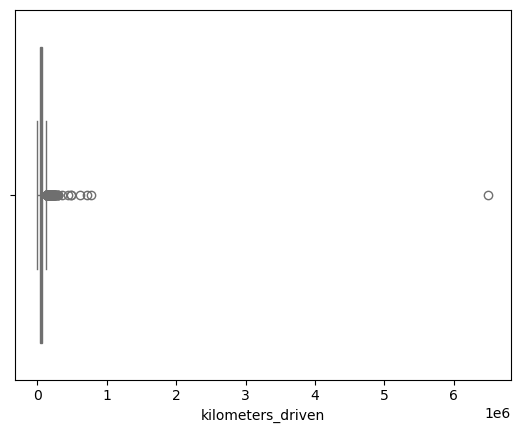

In [364]:
sns.boxplot(x=data["kilometers_driven"], color="skyblue")

In [365]:
data[data["kilometers_driven"] == data["kilometers_driven"].max()]

,location,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,new_price,price,make,model,region,car_age
2328,Chennai,6500000,Diesel,Automatic,First,15.97 kmpl,2993 CC,258 bhp,5.0,NaN,65.0,BMW,X5,South,2


In [366]:
data = data[data["kilometers_driven"] != data["kilometers_driven"].max()]

### mileage column

In [367]:
split_mileage = data["mileage"].str.split(' ', expand=True)
data["mileage"] = split_mileage[0]
data['mileage'] = pd.to_numeric(data["mileage"], errors='coerce')
data.sample(1)

,location,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,new_price,price,make,model,region,car_age
1703,Delhi,65000,Diesel,Automatic,First,12.55,2982 CC,168.5 bhp,7.0,NaN,16.5,Toyota,Fortuner,North,6


The km/kg accounts for ~1% of the dataset.

### engine column

In [368]:
data["engine"] = data["engine"].str.split(' ').str[0]
data['engine'] = pd.to_numeric(data["engine"], errors='coerce')

### power column

In [369]:
data["power"] = data["power"].str.split(' ').str[0]
data['power'] = pd.to_numeric(data["power"], errors='coerce')

### new_price column

In [370]:
data["new_price"].isnull().sum()

np.int64(6244)

In [371]:
# Dropping new_price column since more than 60% of the values are missing
data.drop(columns= ["new_price"], inplace=True)  

### price column

In [372]:
data["price"].isnull().sum()

np.int64(1233)

Since it is the target variable, we cannot simply impute the missing values. Thus, we shall drop rows corresponding to null value in the price column.

In [373]:
data.dropna(subset=['price'], inplace=True)

### Checking data after Cleaning

In [374]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6017 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   location           6017 non-null   object 
 1   kilometers_driven  6017 non-null   int64  
 2   fuel_type          6017 non-null   object 
 3   transmission       6017 non-null   object 
 4   owner_type         6017 non-null   object 
 5   mileage            6015 non-null   float64
 6   engine             5981 non-null   float64
 7   power              5875 non-null   float64
 8   seats              5975 non-null   float64
 9   price              6017 non-null   float64
 10  make               6017 non-null   object 
 11  model              6017 non-null   object 
 12  region             6017 non-null   object 
 13  car_age            6017 non-null   int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 705.1+ KB


In [375]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
kilometers_driven,6017.0,57656.857404,37871.981705,171.00,34000.00,53000.00,73000.00,775000.00
mileage,6015.0,18.136590,4.581908,0.00,15.17,18.16,21.10,33.54
engine,5981.0,1620.783648,600.848537,72.00,1198.00,1493.00,1984.00,5998.00
power,5875.0,113.228412,53.846427,34.20,75.00,97.70,138.10,560.00
seats,5975.0,5.279665,0.806078,2.00,5.00,5.00,5.00,10.00
price,6017.0,9.468825,11.166312,0.44,3.50,5.64,9.95,160.00
car_age,6017.0,5.642180,3.269902,0.00,3.00,5.00,8.00,21.00


- mileage - The min value of 0 implies that the manufacturer supplied mileage stats was not input into the dataset.
- engine - The min value of 72 appears to an outlier and not realistic for car engine size. This will be dealt with later on.

### mileage column revisited
The mileage column has been observed to have a minimum of 0. This implies that the manufacturer supplied mileage stats were not input into the dataset.

In [376]:
data[data["mileage"] == 0]

,location,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,model,region,car_age
14,Pune,85000,Diesel,Automatic,Second,0.0,2179.0,115.0,5.0,17.50,Others,Rover,West,7
67,Coimbatore,15369,Diesel,Automatic,First,0.0,1950.0,194.0,5.0,35.67,Mercedes-Benz,C-Class,South,0
79,Hyderabad,87591,Petrol,Manual,First,0.0,1086.0,NaN,5.0,1.30,Hyundai,Santro,South,14
194,Ahmedabad,60006,Petrol,Manual,First,0.0,NaN,NaN,NaN,2.95,Honda,City,West,12
229,Bangalore,70436,Diesel,Manual,First,0.0,1498.0,99.0,NaN,3.60,Ford,Figo,South,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5647,Mumbai,227000,Diesel,Manual,Fourth & Above,0.0,2446.0,NaN,8.0,2.20,Toyota,Qualis,West,18
5875,Ahmedabad,4000,Diesel,Automatic,First,0.0,1950.0,194.0,5.0,35.00,Mercedes-Benz,C-Class,West,0
5943,Chennai,75000,Diesel,Manual,First,0.0,2112.0,NaN,6.0,1.70,Mahindra,Jeep,South,17
5972,Mumbai,65000,Petrol,Manual,Second,0.0,1086.0,62.0,5.0,1.39,Hyundai,Santro,West,11


 Since this incorrect value of 0 will affect the analysis let replace 0 with NaN.

In [377]:
data["mileage"].replace(to_replace=0, value= np.nan, inplace=True)

## Missing value imputation

In [378]:
data.isnull().sum()

location               0
kilometers_driven      0
fuel_type              0
transmission           0
owner_type             0
mileage               70
engine                36
power                142
seats                 42
price                  0
make                   0
model                  0
region                 0
car_age                0
dtype: int64

It is possible to impute the missing values of the engine, seats, power and mileage by comparing like for like car names where the values are available in the dataset.

In [379]:
# Temporary column that will be deleted later on
data['car_name'] = data[['make', 'model']].apply(lambda x: ' '.join(x), axis=1)

### power column

In [380]:
# Fill missing power with the mean power for that car_name
data["power"] = data.groupby("car_name")["power"].transform(lambda x: x.fillna(x.mean()))

In [381]:
data["power"].isnull().sum()
# Still there are 11 data points with missing power values, we will drop them

np.int64(11)

In [382]:
data = data.dropna(subset=['power'])

### mileage column

In [383]:
data["mileage"] = data.groupby("car_name")["mileage"].transform(lambda x: x.fillna(x.mean()))
data["mileage"].isnull().sum()

np.int64(5)

In [384]:
data[data["mileage"].isnull()]

,location,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,model,region,car_age,car_name
67,Coimbatore,15369,Diesel,Automatic,First,NaN,1950.0,194.0,5.0,35.67,Mercedes-Benz,C-Class,South,0,Mercedes-Benz C-Class
962,Mumbai,8682,Diesel,Automatic,First,NaN,1950.0,194.0,5.0,39.50,Mercedes-Benz,C-Class,West,1,Mercedes-Benz C-Class
4446,Chennai,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.00,Mahindra,E,South,3,Mahindra E
4904,Mumbai,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,12.75,Toyota,Prius,West,8,Toyota Prius
5875,Ahmedabad,4000,Diesel,Automatic,First,NaN,1950.0,194.0,5.0,35.00,Mercedes-Benz,C-Class,West,0,Mercedes-Benz C-Class


In [385]:
data = data.dropna(subset=['mileage'])

### seats column

In [386]:
data["seats"] = data.groupby("car_name")["seats"].transform(lambda x: x.fillna(x.mean()))
data["seats"].isnull().sum()

np.int64(0)

### engine column

In [387]:
data["engine"] = data.groupby("car_name")["engine"].transform(lambda x: x.fillna(x.mean()))
data["engine"].isnull().sum()

np.int64(0)

In [388]:
# info of the dataframe after cleaning & imputation
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6001 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   location           6001 non-null   object 
 1   kilometers_driven  6001 non-null   int64  
 2   fuel_type          6001 non-null   object 
 3   transmission       6001 non-null   object 
 4   owner_type         6001 non-null   object 
 5   mileage            6001 non-null   float64
 6   engine             6001 non-null   float64
 7   power              6001 non-null   float64
 8   seats              6001 non-null   float64
 9   price              6001 non-null   float64
 10  make               6001 non-null   object 
 11  model              6001 non-null   object 
 12  region             6001 non-null   object 
 13  car_age            6001 non-null   int64  
 14  car_name           6001 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 750.1+ KB


In [389]:
data.describe()

,kilometers_driven,mileage,engine,power,seats,price,car_age
count,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000
mean,57679.763373,18.322599,1620.031973,112.616977,5.280155,9.454309,5.632061
std,37874.166625,4.165335,599.474062,53.707185,0.801404,11.145140,3.253347
min,171.000000,6.400000,624.000000,34.200000,2.000000,0.440000,0.000000
25%,34000.000000,15.300000,1198.000000,75.000000,5.000000,3.500000,3.000000
50%,53000.000000,18.160000,1493.000000,93.700000,5.000000,5.640000,5.000000
75%,73000.000000,21.100000,1984.000000,138.100000,5.000000,9.950000,8.000000
max,775000.000000,33.540000,5998.000000,560.000000,10.000000,160.000000,21.000000


## Univariate analysis

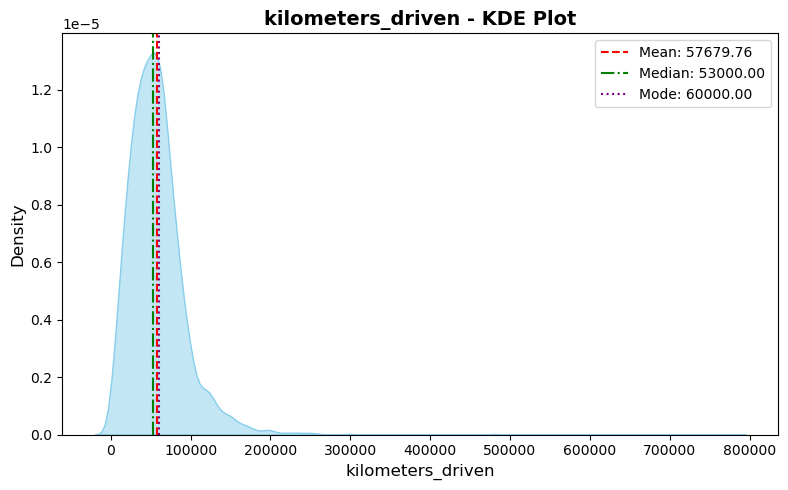

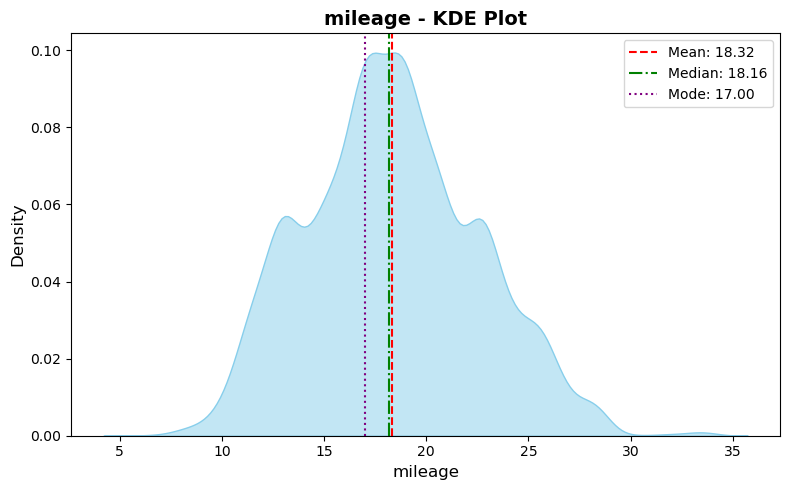

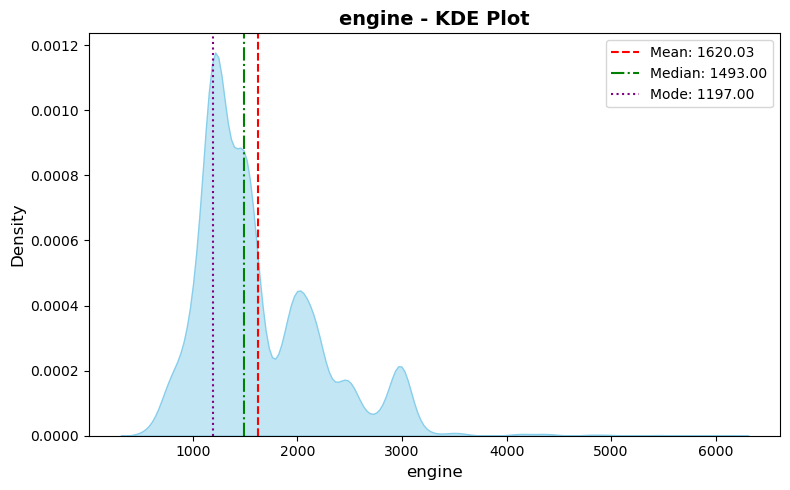

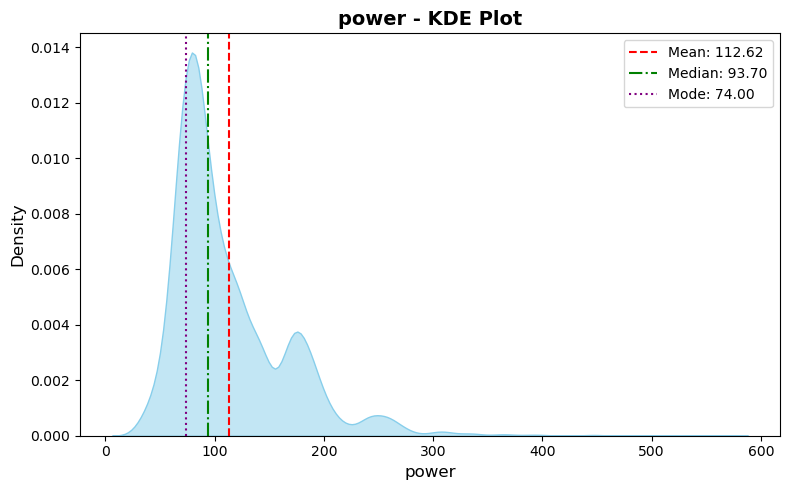

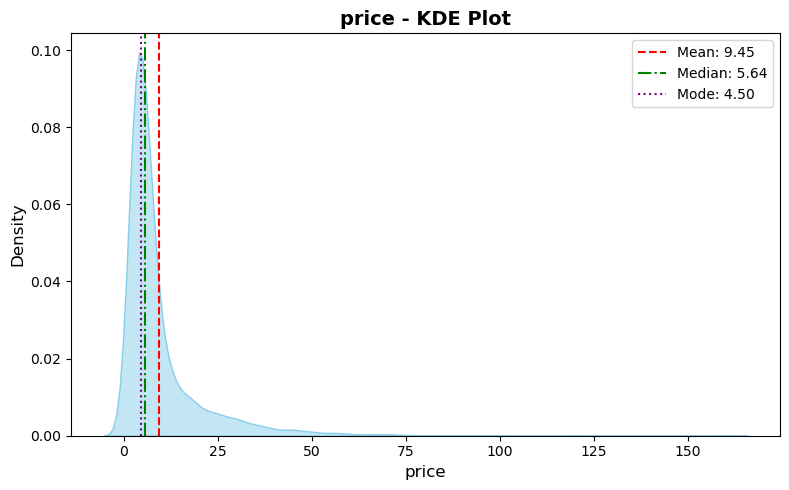

In [390]:
num_cols = ['kilometers_driven', 'mileage', 'engine', 'power', 'price']

for col in num_cols:
    plt.figure(figsize=(8, 5))
    
    sns.kdeplot(data[col].dropna(), fill=True, color="skyblue", alpha=0.5)
    
    # Mean, median, and mode
    mean_val = data[col].mean()
    median_val = data[col].median()
    mode_val = data[col].mode()[0]
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:.2f}")
    plt.axvline(median_val, color="green", linestyle="-.", linewidth=1.5, label=f"Median: {median_val:.2f}")
    plt.axvline(mode_val, color="purple", linestyle=":", linewidth=1.5, label=f"Mode: {mode_val:.2f}")
    
    # Titles & labels
    plt.title(f"{col} - KDE Plot", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


In [391]:
for col in num_cols:
    print(f"{col} - Skewness: {data[col].skew()}, Kurtosis: {data[col].kurtosis()}")

kilometers_driven - Skewness: 4.216891120069619, Kurtosis: 53.82812287419129
mileage - Skewness: 0.22228177274761796, Kurtosis: -0.27265900074108895
engine - Skewness: 1.4272961156444177, Kurtosis: 3.1364512036642926
power - Skewness: 1.9235300489338012, Kurtosis: 6.530640852908534
price - Skewness: 3.3550938371311014, Kurtosis: 17.349379688081857


## Categorical columns

In [392]:
cat_cols = ['make', 'car_age', 'fuel_type', 'transmission', 'owner_type', 'seats' ]

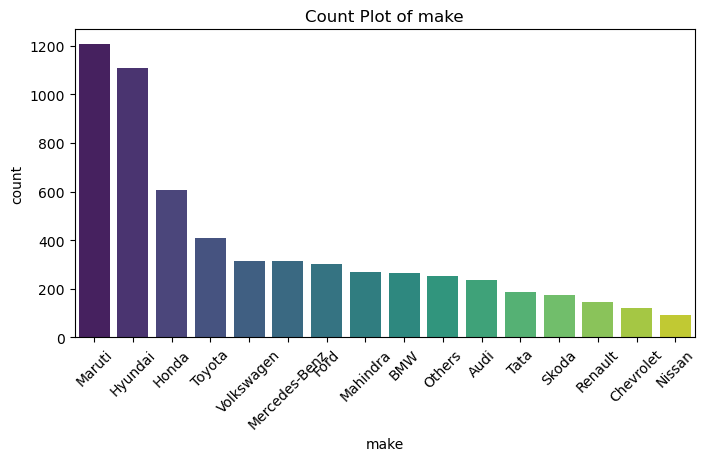

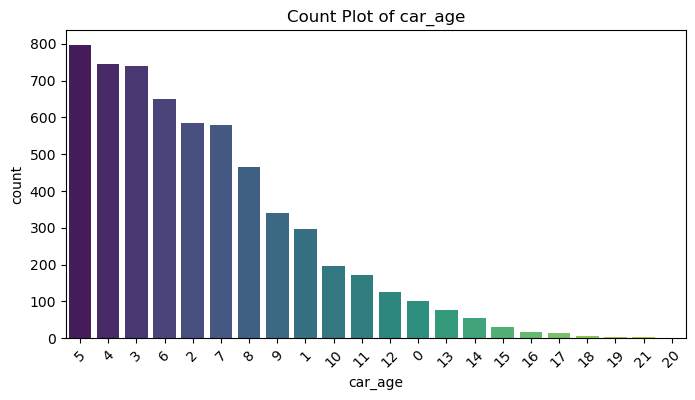

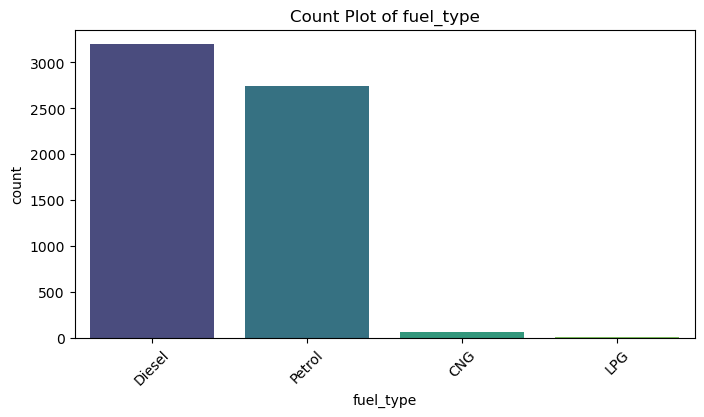

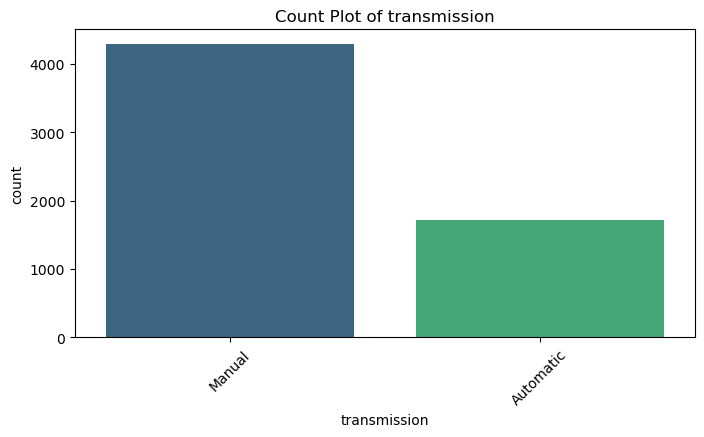

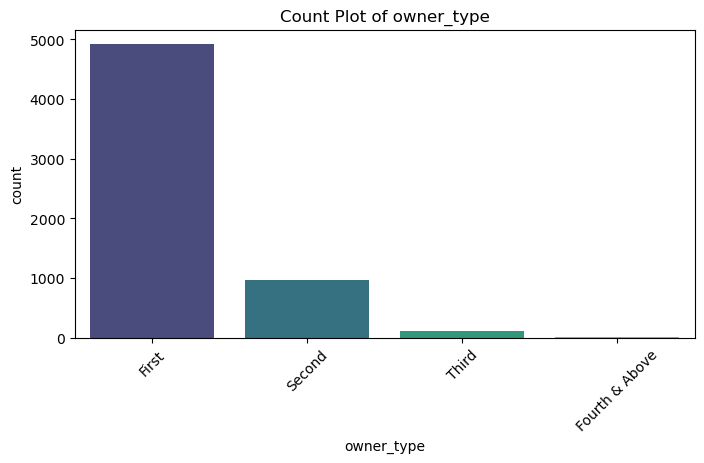

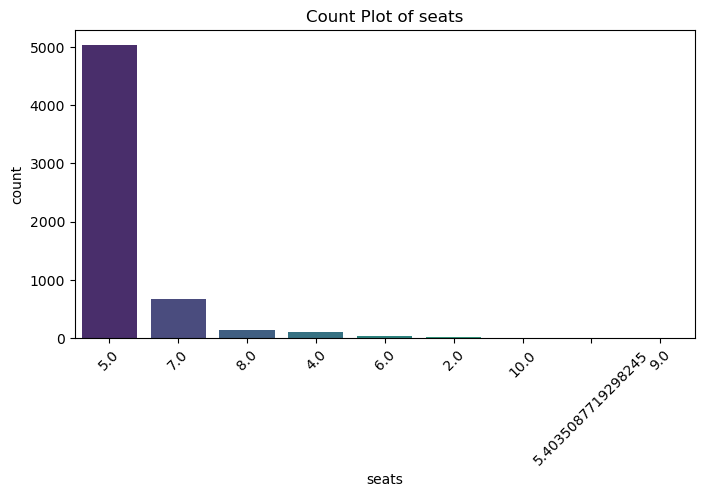

In [393]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data, x=col, order=data[col].value_counts().index, palette="viridis")
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

## Multivariate Analysis
### Correlation Analysis

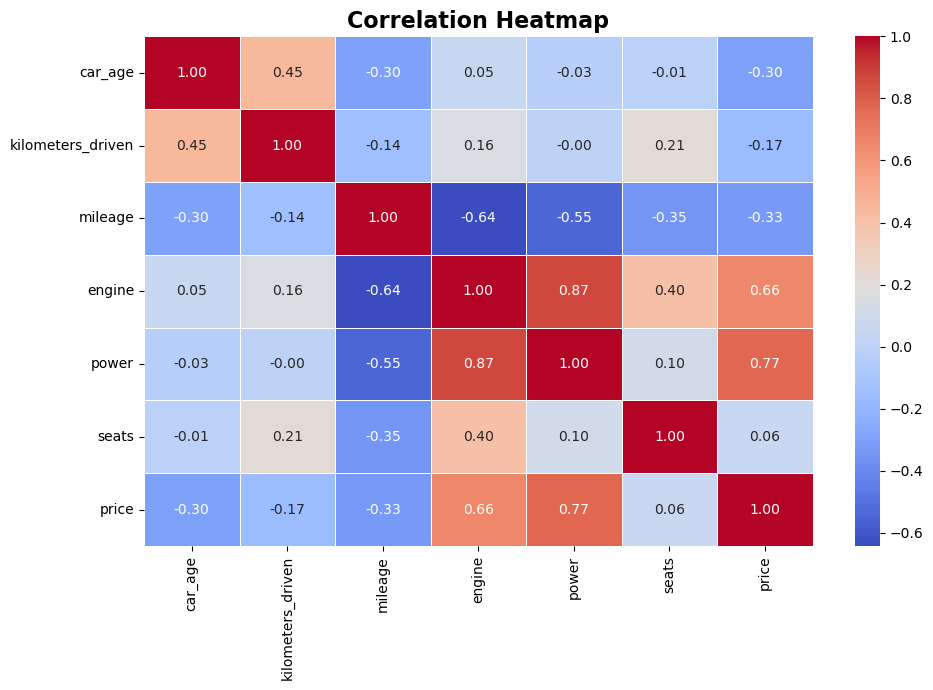

In [394]:
corr_cols = ['car_age', 'kilometers_driven', 'mileage', 'engine', 'power', 'seats', 'price']
# Calculate correlation matrix
corr_matrix = data[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",linewidths=0.5)

plt.title("Correlation Heatmap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

The engine and power variables were highly positively correlated. In the context of vehicles, the bigger the engine size the more powerful is the vehicle. Therefore the power variable will also be dropped.

In [395]:
data["power_per_cc"] = data["power"] / data["engine"]

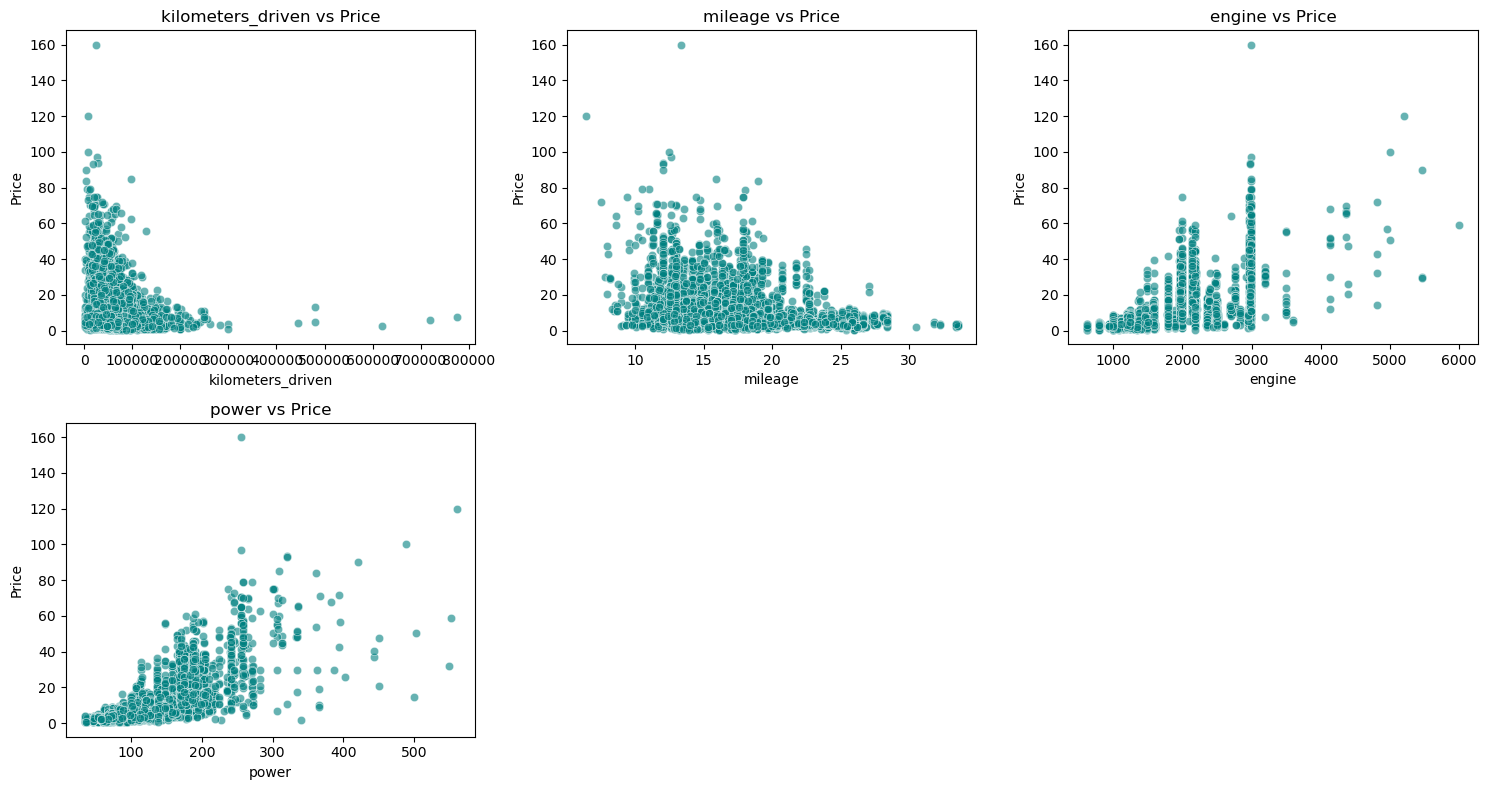

In [396]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(x=data[col], y=data['price'], ax=axes[i], alpha=0.6, color='teal')
    axes[i].set_title(f'{col} vs Price')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

axes[-1].set_visible(False)
axes[-2].set_visible(False)

plt.tight_layout()
plt.show()


<Axes: xlabel='price', ylabel='Density'>

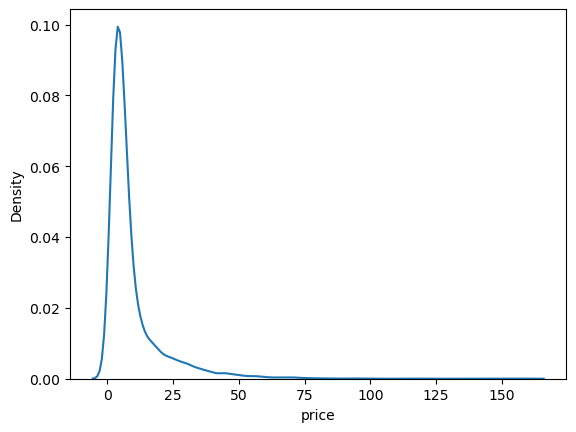

In [397]:
sns.kdeplot(data['price'])

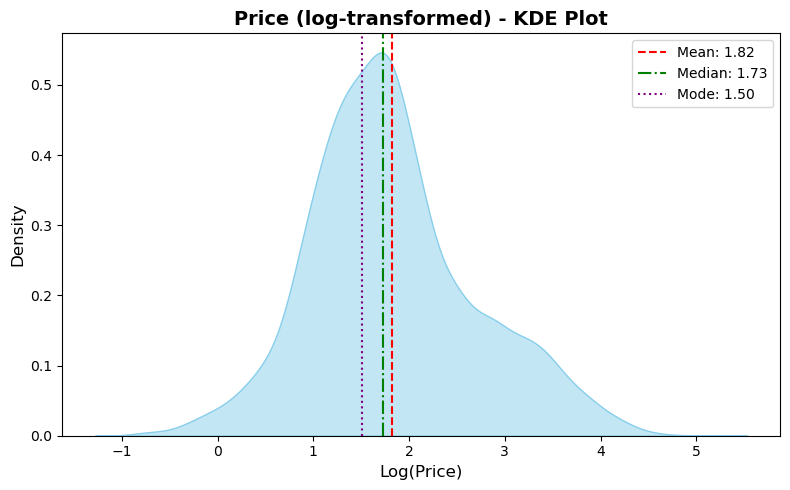

In [398]:
### Log transform the target column
data["price"] = np.log(data['price'])

plt.figure(figsize=(8, 5))

# KDE Plot
sns.kdeplot(data["price"], fill=True, color="skyblue", alpha=0.5)

# Mean, median, mode
mean_val = data["price"].mean()
median_val = data["price"].median()
mode_val = data["price"].mode()[0]

plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=1.5, label=f"Median: {median_val:.2f}")
plt.axvline(mode_val, color="purple", linestyle=":", linewidth=1.5, label=f"Mode: {mode_val:.2f}")

# Titles & labels
plt.title("Price (log-transformed) - KDE Plot", fontsize=14, fontweight="bold")
plt.xlabel("Log(Price)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [399]:
data.to_csv("cleaned_used_cars_data.csv")

## Data Preparation

### Creating a clone dataset

In [400]:
df = data.copy()

In [401]:
df.head()

,location,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price,make,model,region,car_age,car_name,power_per_cc
0,Mumbai,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,0.559616,Maruti,Wagon,West,9,Maruti Wagon,0.058277
1,Pune,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,2.525729,Hyundai,Creta,West,4,Hyundai Creta,0.079772
2,Chennai,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,1.504077,Honda,Jazz,South,8,Honda Jazz,0.073978
3,Chennai,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,1.791759,Maruti,Ertiga,South,7,Maruti Ertiga,0.071122
4,Coimbatore,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,2.875822,Audi,A4,South,6,Audi A4,0.071545


In [402]:
df.columns

Index(['location', 'kilometers_driven', 'fuel_type', 'transmission',
       'owner_type', 'mileage', 'engine', 'power', 'seats', 'price', 'make',
       'model', 'region', 'car_age', 'car_name', 'power_per_cc'],
      dtype='object')

### Dropping unnecessary columns

In [403]:
drop_cols = ['model',  'location', 'car_name', 'engine', 'power']
df.drop(columns = drop_cols, inplace=True)

In [404]:
df.head()

,kilometers_driven,fuel_type,transmission,owner_type,mileage,seats,price,make,region,car_age,power_per_cc
0,72000,CNG,Manual,First,26.60,5.0,0.559616,Maruti,West,9,0.058277
1,41000,Diesel,Manual,First,19.67,5.0,2.525729,Hyundai,West,4,0.079772
2,46000,Petrol,Manual,First,18.20,5.0,1.504077,Honda,South,8,0.073978
3,87000,Diesel,Manual,First,20.77,7.0,1.791759,Maruti,South,7,0.071122
4,40670,Diesel,Automatic,Second,15.20,5.0,2.875822,Audi,South,6,0.071545


In [405]:
df.columns

Index(['kilometers_driven', 'fuel_type', 'transmission', 'owner_type',
       'mileage', 'seats', 'price', 'make', 'region', 'car_age',
       'power_per_cc'],
      dtype='object')

## Train-test split

In [406]:
X = df.drop(['price'], axis=1)
y = df[['price']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 4200
Number of rows in test data = 1801


In [407]:
X_train.head()

,kilometers_driven,fuel_type,transmission,owner_type,mileage,seats,make,region,car_age,power_per_cc
5328,47000,Diesel,Automatic,First,22.69,5.0,BMW,South,4,0.095238
5658,85000,Petrol,Manual,Second,13.80,5.0,Ford,West,13,0.053888
1790,73500,Petrol,Manual,Second,13.00,5.0,Honda,West,15,0.067014
3980,70000,Petrol,Manual,First,18.90,5.0,Maruti,West,9,0.067234
5561,30000,Diesel,Automatic,First,14.94,5.0,Audi,South,5,0.081362


### Outlier Detection & Removal

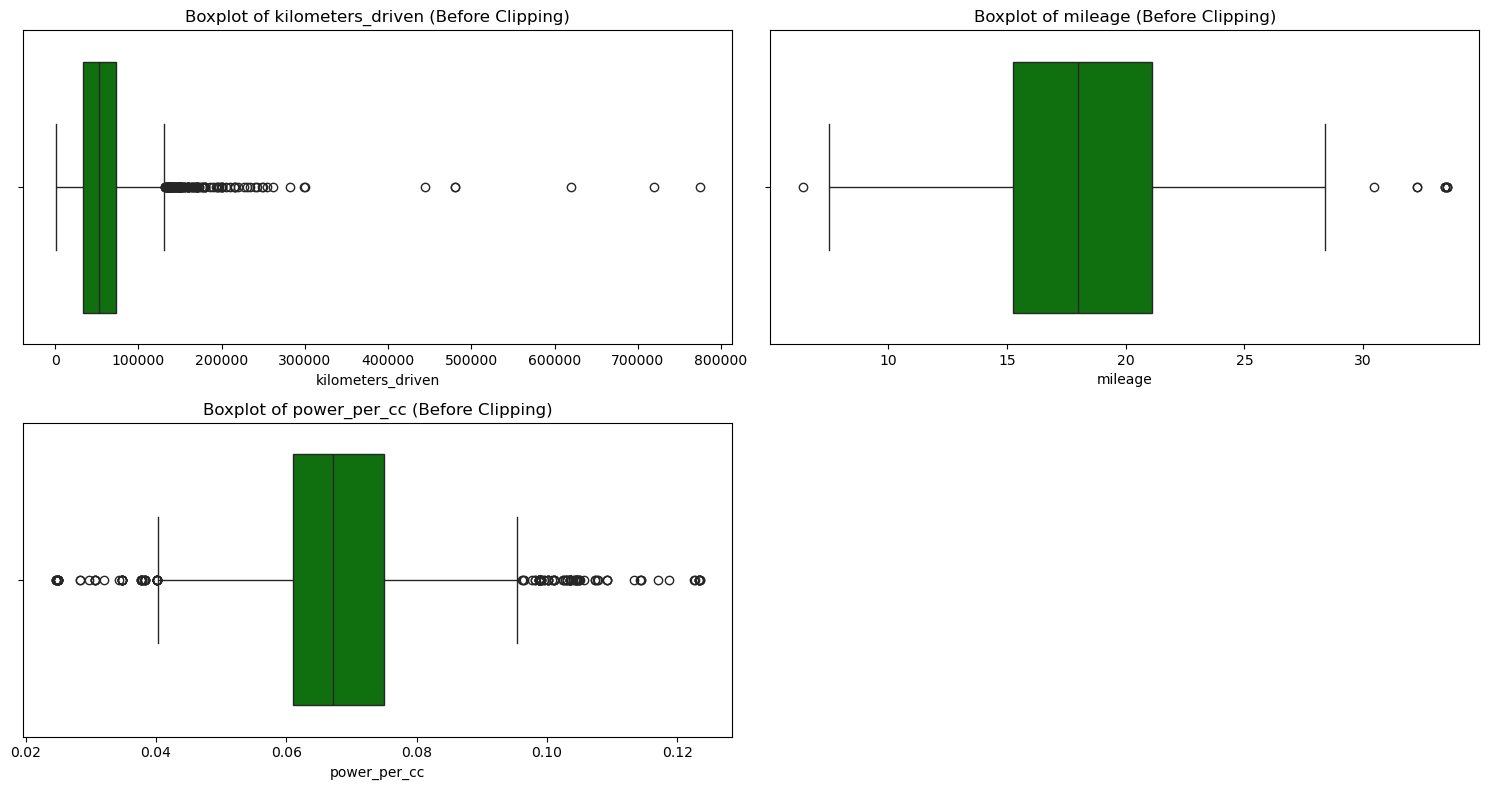

In [408]:
num_cols_train = ['kilometers_driven', 'mileage', 'power_per_cc']
# Boxplots BEFORE clipping
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(num_cols_train):
    sns.boxplot(x=X_train[col], color="green", ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} (Before Clipping)")

axes[-1].set_visible(False)  
plt.tight_layout()
plt.show()

seats and car_age are categorical variables which we shall not do any outlier corrections.

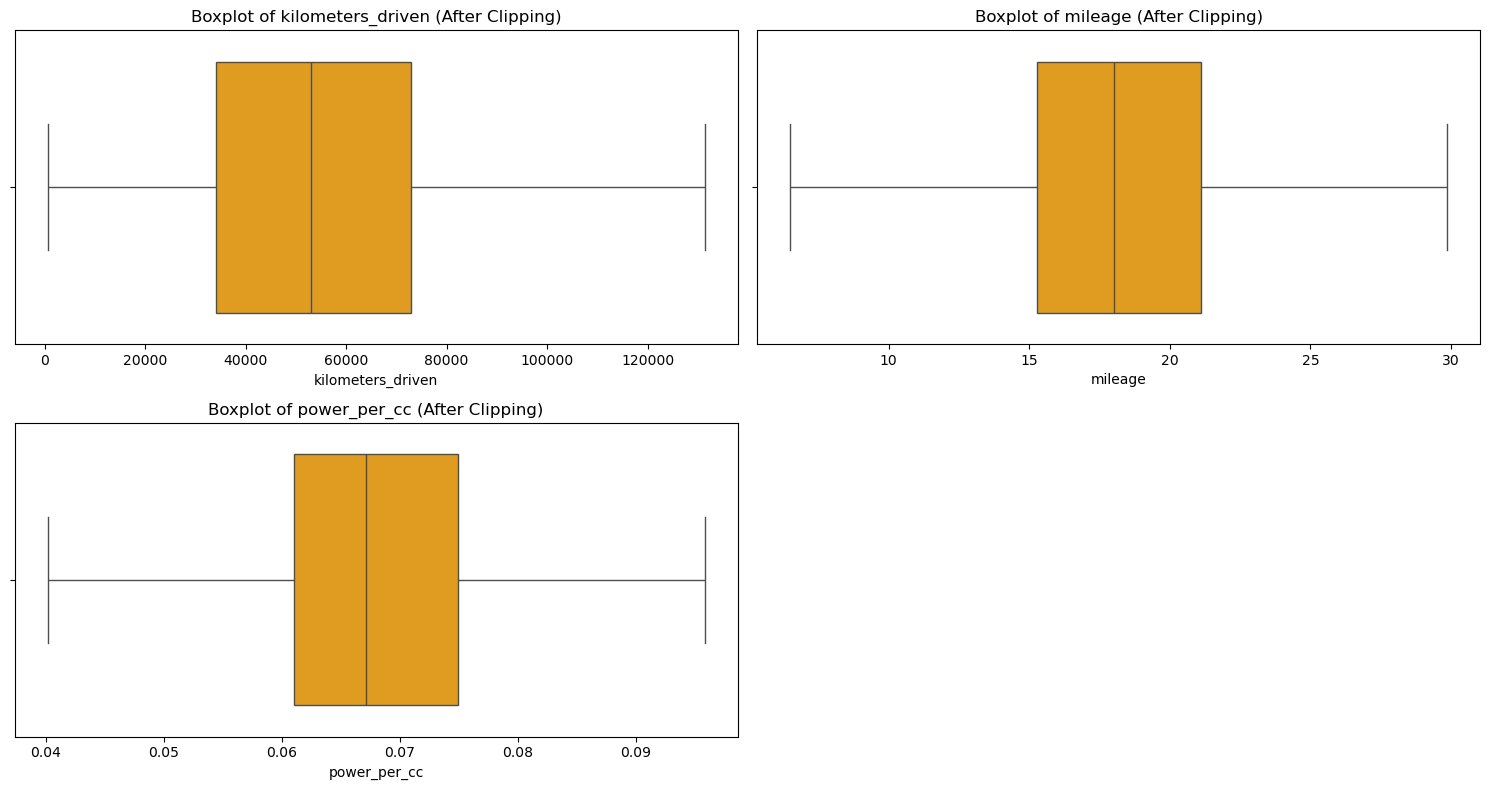

In [409]:
# Outlier clipping using IQR method
for col in num_cols_train:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[col] = X_train[col].clip(lower_bound, upper_bound)

# Boxplots AFTER clipping
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(num_cols_train):
    sns.boxplot(x=X_train[col], color="orange", ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} (After Clipping)") 

axes[-1].set_visible(False)            
plt.tight_layout()
plt.show()

### Testing for Multicollinearity using VIF scores
1. If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and hence the variance of β̂k is not inflated at all.
2. if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

In [410]:
corr_cols

['car_age',
 'kilometers_driven',
 'mileage',
 'engine',
 'power',
 'seats',
 'price']

In [411]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
mult_cols = ['car_age', 'kilometers_driven', 'mileage', 'power_per_cc', 'seats']
mult = X_train[mult_cols]  # num_cols = your numerical predictors list

# Add constant term for intercept
mult = sm.add_constant(mult)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Feature"] = mult.columns
vif_data["VIF"] = [variance_inflation_factor(mult.values, i)
                   for i in range(mult.shape[1])]

print(vif_data)

             Feature         VIF
0              const  283.857731
1            car_age    1.659709
2  kilometers_driven    1.488521
3            mileage    1.524639
4       power_per_cc    1.369193
5              seats    1.540247


In [412]:
X_train.head()

,kilometers_driven,fuel_type,transmission,owner_type,mileage,seats,make,region,car_age,power_per_cc
5328,47000.0,Diesel,Automatic,First,22.69,5.0,BMW,South,4,0.095238
5658,85000.0,Petrol,Manual,Second,13.80,5.0,Ford,West,13,0.053888
1790,73500.0,Petrol,Manual,Second,13.00,5.0,Honda,West,15,0.067014
3980,70000.0,Petrol,Manual,First,18.90,5.0,Maruti,West,9,0.067234
5561,30000.0,Diesel,Automatic,First,14.94,5.0,Audi,South,5,0.081362


## Encoding Categorical features & Scaling using Pipeline

In [413]:
trf = ColumnTransformer([
    # One-hot encode selected categorical columns
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), ['fuel_type', 'owner_type', 'region', 'transmission', 'make']),
    
    # Scale selected numeric columns
    ('scaling', StandardScaler(), [ 'kilometers_driven', 'mileage', 'power_per_cc']),
    
    # Log-transform skewed numeric columns
    ('log_transform', FunctionTransformer(func=lambda x: np.log1p(x), validate=True), 
     ['kilometers_driven', 'mileage', 'power_per_cc', ])  
], remainder='passthrough')

## Linear Regression

In [414]:
lr = LinearRegression()

pipe = Pipeline([
    ('trf', trf),
    ('model', lr)
])

pipe.fit(X_train, y_train)

# Predictions
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [415]:
print("Training R²:", r2_score(y_train, y_train_pred))
print("Testing R²:", r2_score(y_test, y_test_pred))

print("Training RMSE:",  np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Testing MAE:", mean_absolute_error(y_test, y_test_pred))

# Cross validation
cv_scores = cross_val_score(pipe, X, y, cv=10, scoring='r2')
print("10-Fold CV R² Scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

Training R²: 0.8936099516531483
Testing R²: 0.892076192521276
Training RMSE: 0.28826108617494417
Testing RMSE: 0.27612639881619017
Training MAE: 0.21534647532880974
Testing MAE: 0.20427297331884836
10-Fold CV R² Scores: [0.91099868 0.89401563 0.87924858 0.89606217 0.89450158 0.87210314
 0.86564288 0.89720444 0.8992465  0.8919649 ]
Mean CV R²: 0.890098849845862


#### Linear Regression Assumptions
- No Multicollinearity
- Linearity of variables
- Normality of residuals(error terms)
- No autocorrelation (Independence of Residuals)
- No Heteroscedacity

### Linearity
Checking if the relationship between predictors and target is linear.

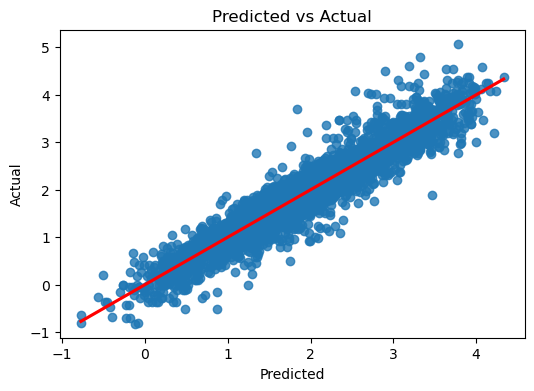

In [416]:
plt.figure(figsize=(6, 4))
sns.regplot(x= y_train_pred, y=y_train, line_kws={"color": "red"})
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Normality of Error terms

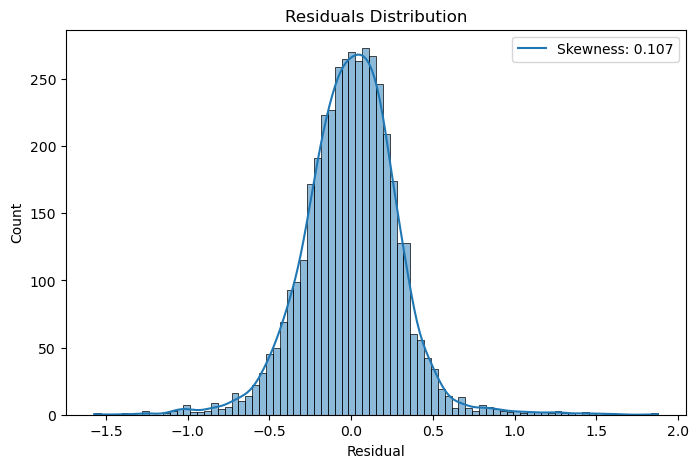

Skewness of the residuals:  0.10746810595096928
Mean of the residuals:  -1.457648816464522e-14


In [417]:
# Residual analysis
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='skyblue', label=None)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
skew_val = float(residuals.skew())
plt.legend([f"Skewness: {skew_val:.3f}"])
plt.show()

print("Skewness of the residuals: ", skew_val)
print("Mean of the residuals: ", float(residuals.mean()))

The residuals follow a normal distribution.

### No autocorrelation
Checking if the residuals are independent.

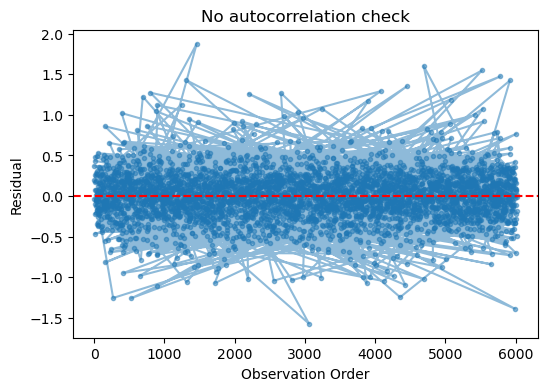

In [418]:
# Method 1
plt.figure(figsize=(6,4))
plt.plot(residuals, marker='.', linestyle='-', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observation Order")
plt.ylabel("Residual")
plt.title("No autocorrelation check")
plt.show()

No clear pattern implies independence of the residuals.

In [419]:
# Method 2 - Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
print("Durbin-Watson statistic:", durbin_watson(residuals))


Durbin-Watson statistic: [2.01822442]


Value close to 2 means independence (0–4 range) & <1 or >3 indicates strong autocorrelation.

### Homoscedasticity
Constant variance of residuals across all levels of predictors.

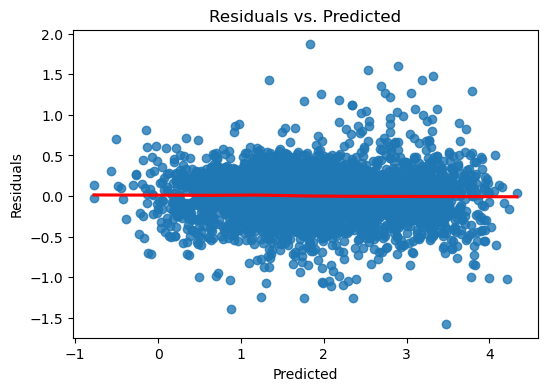

In [420]:
plt.figure(figsize=(6,4))
sns.regplot(x= np.ravel(y_train_pred), y =np.ravel(residuals), lowess=True, line_kws={'color': 'red'})
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

The variance of the residuals relatively constant with Prediction which implies that Homoscedasticity exists.

## Decision Tree

In [421]:
dt= DecisionTreeRegressor(max_depth=6, random_state=42, min_samples_split=50)

pipe = Pipeline([
    ('trf', trf),
    ('model', dt)
])

pipe.fit(X_train, y_train)

# Predictions
y_train_pred_dt = pipe.predict(X_train)
y_test_pred_dt = pipe.predict(X_test)

print("Decision Tree R² (Train):", r2_score(y_train, y_train_pred_dt))
print("Decision Tree R² (Test):", r2_score(y_test, y_test_pred_dt))
print("Decision Tree RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_test_pred_dt)))

cv_scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2')
np.mean(cv_scores)

Decision Tree R² (Train): 0.8328760167618734
Decision Tree R² (Test): 0.7891420144058285
Decision Tree RMSE (Test): 0.3859618028011744


np.float64(0.7972798086981119)

## Random Forest

In [422]:
rf= RandomForestRegressor(n_estimators=100, min_samples_split=60, random_state=42)

pipe = Pipeline([
    ('trf', trf),
    ('model', rf)
])

pipe.fit(X_train, y_train)

# Predictions
y_train_pred_rf = pipe.predict(X_train)
y_test_pred_rf = pipe.predict(X_test)

print("Decision Tree R² (Train):", r2_score(y_train, y_train_pred_rf))
print("Decision Tree R² (Test):", r2_score(y_test, y_test_pred_rf))
print("Decision Tree RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))

cv_scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2')
np.mean(cv_scores)

Decision Tree R² (Train): 0.9062820539017227
Decision Tree R² (Test): 0.8847788699963648
Decision Tree RMSE (Test): 0.28530892982230743


np.float64(0.874965317220702)